## Model Martingale

In [71]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd() + "/../..")
from utils import plot_correlogram
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import combine_data
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram, nmae, nmae_scorer, mape_scorer, mean_squared_error_scorer
from typing import Dict
from sklearn.utils import shuffle
import tqdm

#vis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [72]:
meta, data =pd.read_pickle("../../data/forecast_data_2020.p")

In [73]:
homes_indexes = data.columns.get_level_values(0).unique()

In [74]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h

In [90]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float))

### Current consumption (thi will be used as prediction)
consumption at step T-1 won't require any shift

In [91]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float))

In [92]:
feature_union = fe.make_union(prev_consumption,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype',
                                                       CastType())])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('casttype',
                                                       CastType())]))])

## Transform

In [93]:
def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in list(home_indexes_subsample):
        if home_i == "268": # outlier
            continue
        temp_df = data[home_i]
        temp_df["time"] = temp_df.index
        temp_df = feature_union.fit_transform(temp_df)
        temp_df = temp_df.reset_index().drop_duplicates(subset='time', keep="last").set_index("time")
        temp_df["home_num"] = home_i

        df_dict[home_i] = temp_df
    return df_dict

#Train data
homes_indexes_subsample = np.random.choice(homes_indexes,99,replace =False)
df_dict_train = create_samples(train_homes_indexes_subsample)
df_train = combine_data(df_dict_train)

In [94]:
df_train.columns

Index(['consumption', 'forward_consumption_48', 'home_num'], dtype='object')

In [95]:
FEATURES = ['consumption','home_num']
TARGET = 'forward_consumption_48'

## Note X is prediction for y
E[Y_{t+1}| F] = Y_{t}

In [96]:
X, y = df_train[FEATURES], df_train[TARGET]

In [97]:
print(X.shape)

(864963, 2)


## Model Prediction on Individual House Train

In [98]:
df_dict_train.keys()

dict_keys(['657', '188', '131', '801', '999', '957', '993', '222', '456', '113', '514', '890', '640', '267', '250', '272', '901', '780', '827', '763', '677', '604', '318', '424', '666', '595', '200', '744', '363', '600', '231', '743', '923', '624', '945', '842', '987', '521', '644', '683', '822', '980', '859', '875', '396', '247', '441', '192', '618', '947', '986', '925', '438', '906', '352', '319', '480', '474', '340', '484', '460', '854', '554', '290', '909', '629', '992', '745', '522', '912', '246', '852', '706', '621', '601', '118', '260', '927', '255', '412', '351', '313', '889', '194', '130', '977', '241', '238', '123', '219', '464', '583', '525', '598', '261', '462', '244', '404', '299'])

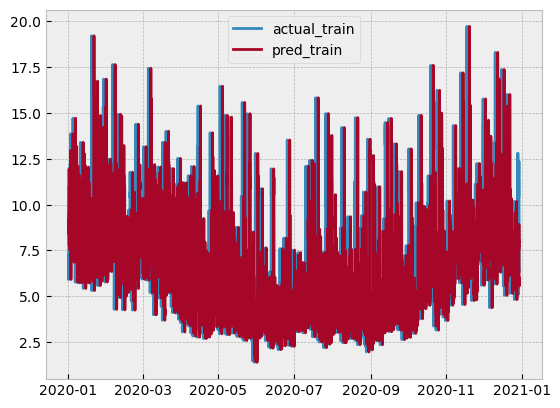

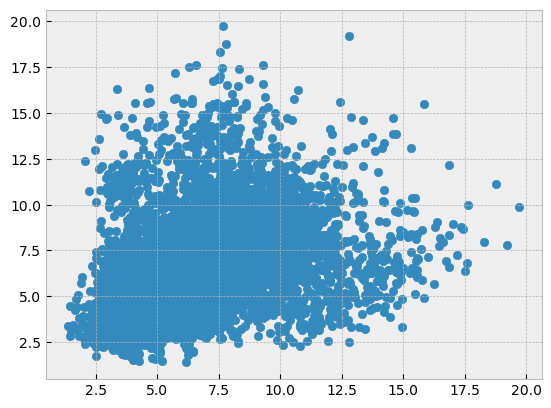

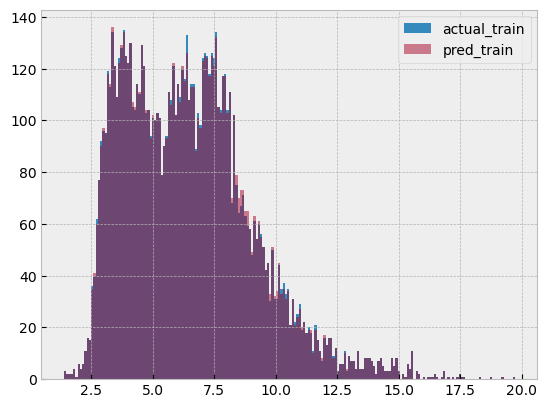

In [99]:
home_num = '131'
X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
pred = X_train["consumption"]
pred_home_train_single = pd.DataFrame({
                            "actual": y_train,
                            "pred": pred,
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

In [100]:
nmae(pred_home_train_single["actual"], pred_home_train_single["pred"])

0.2815446916142935

# Porfolio prediction on Train Data Set

In [101]:
pred_home_train = {}
for home_num in df_dict_train.keys():
    X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
    pred = X_train["consumption"]
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": y_train,
                                 "pred": pred,
                                 "home_num" : home_num})
    

In [102]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

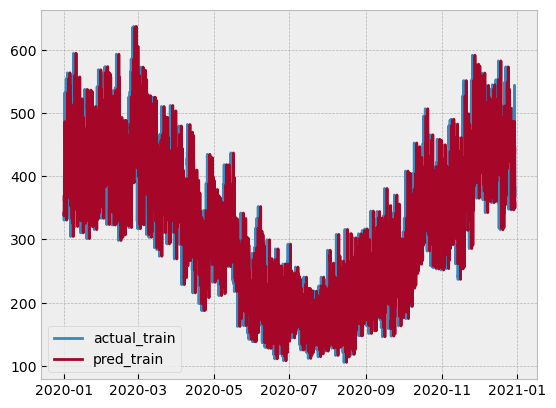

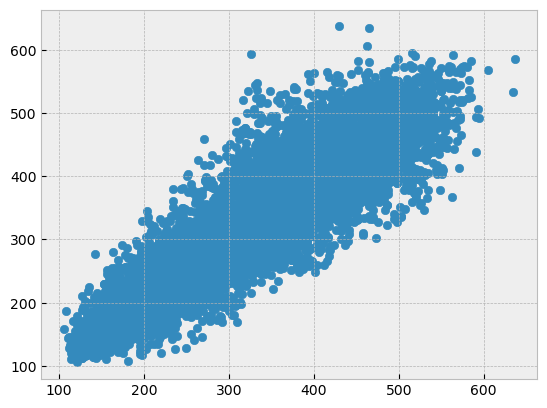

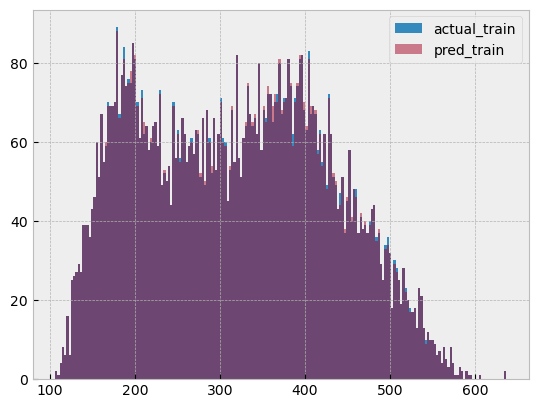

In [103]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [104]:
nmae(portfolio_actual_train, portfolio_pred_train)

0.11557326084335742